In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# The file has .xlsx extension, so use read_excel instead of read_csv to avoid UnicodeDecodeError
df_wbdi = pd.read_csv('/Users/megankelly/ASDA/ASDA_2025_Group_2_Portfolio_-1/datasets/world_bank_development_indicators.csv')

df_income = pd.ExcelFile('/Users/megankelly/ASDA/ASDA_2025_Group_2_Portfolio_-1/datasets/income.xlsx')

# Display sheet names in the Excel file
print("Sheet names in the Excel file:", df_income.sheet_names)

df_income_economies = pd.read_excel(df_income, sheet_name='List of economies')
#df_income_composition = pd.read_excel(df_income, sheet_name='composition')
#df_income_notes = pd.read_excel(df_income, sheet_name='notes')


Sheet names in the Excel file: ['List of economies', 'composition', 'notes']


In [17]:
df_wbdi.shape

(17272, 50)

In [18]:
# Add income/region information by merging the tables into a single dataframe.
df_wbdi = df_wbdi.merge(df_income_economies[['Economy', 'Income group', 'Region']], 
                       how='left', 
                       left_on='country', 
                       right_on='Economy').drop(columns=['Economy'])

In [19]:
# Cleaning: Clean up countries (some have weird names, e.g. post-demographic dividend)
df_wbdi['country'].unique()


# Drop rows that have a missing income group
df_wbdi = df_wbdi[~df_wbdi['Income group'].isna()]



In [20]:
# Impute or drop missing values
# Drop missing values where life expectancy is missing (as this is the variable I want to analyze)
print(df_wbdi['life_expectancy_at_birth'].isnull().sum())
df_wbdi = df_wbdi[~df_wbdi['life_expectancy_at_birth'].isna()]


1006


In [21]:
# Duplicates
print(df_wbdi.duplicated().sum())

# do not need to be dropped as there are none

0


In [22]:
# display the first, the last and a random sample of 7 entries
df_wbdi.head(1)
df_wbdi.tail(1)
df_wbdi.sample(7)

,country,date,agricultural_land%,forest_land%,land_area,avg_precipitation,trade_in_services%,control_of_corruption_estimate,control_of_corruption_std,access_to_electricity%,...,birth_rate,death_rate,life_expectancy_at_birth,population,rural_population,voice_and_accountability_estimate,voice_and_accountability_std,intentional_homicides,Income group,Region
499,Angola,2011-01-01,36.348761,57.433976,1246700.0,1010.0,21.828607,-1.367469,0.158418,34.600000,...,44.364,10.630,57.596,24259111.0,9575556.0,-1.125478,0.111697,4.348881,Lower middle income,Sub-Saharan Africa
12504,Paraguay,2021-01-01,42.308432,39.826143,397300.0,NaN,8.309117,-1.025977,0.167787,100.000000,...,20.627,7.638,70.262,6703799.0,2514193.0,0.004174,0.129606,7.831380,Upper middle income,Latin America & Caribbean
15442,Tanzania,1984-01-01,34.996613,NaN,885800.0,1071.0,NaN,NaN,NaN,NaN,...,46.496,15.050,51.546,21857176.0,18293363.0,NaN,NaN,NaN,Lower middle income,Sub-Saharan Africa
16138,Tuvalu,2009-01-01,60.000000,33.333333,30.0,NaN,106.726292,-0.219170,0.406062,96.465469,...,22.186,9.973,63.949,10408.0,4810.0,0.741996,0.232784,0.000000,Upper middle income,East Asia & Pacific
11550,Nigeria,1963-01-01,59.807635,NaN,910770.0,1150.0,NaN,NaN,NaN,NaN,...,46.421,25.594,38.192,47822569.0,40129352.0,NaN,NaN,NaN,Lower middle income,Sub-Saharan Africa
8232,Kosovo,1971-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.803,8.258,64.874,1247000.0,NaN,NaN,NaN,NaN,Upper middle income,Europe & Central Asia
14382,South Sudan,1979-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.763,25.861,37.919,4092792.0,3743636.0,NaN,NaN,NaN,Low income,Sub-Saharan Africa


In [23]:
# Get data type of relevant columns (live expectancy and income)
# @group add data types of relevant columns in your analysis here
df_wbdi[['life_expectancy_at_birth', 'Region']].dtypes


life_expectancy_at_birth    float64
Region                       object
dtype: object

In [24]:
# basic summary statistics for both categorical and numerical variables
df_wbdi.describe()
df_wbdi.dtypes

country                                       object
date                                          object
agricultural_land%                           float64
forest_land%                                 float64
land_area                                    float64
avg_precipitation                            float64
trade_in_services%                           float64
control_of_corruption_estimate               float64
control_of_corruption_std                    float64
access_to_electricity%                       float64
renewvable_energy_consumption%               float64
electric_power_consumption                   float64
CO2_emisions                                 float64
other_greenhouse_emisions                    float64
population_density                           float64
inflation_annual%                            float64
real_interest_rate                           float64
risk_premium_on_lending                      float64
research_and_development_expenditure%        f

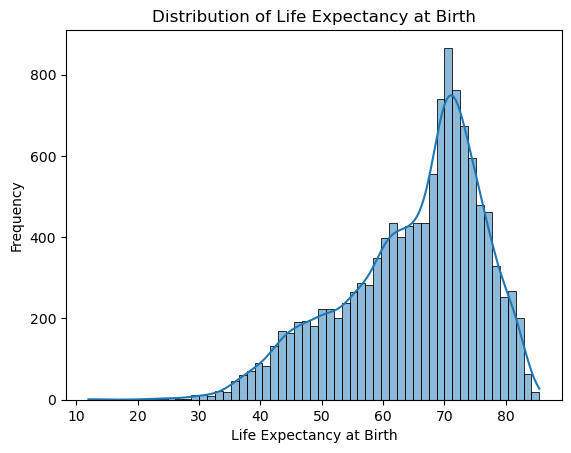

In [25]:
# basic plots for categorical and numerical variables to check distributions and counts
# @group add plotting of relevant columns in your analysis below

# life expectancy distribution
sns.histplot(data=df_wbdi, x='life_expectancy_at_birth', kde=True)
plt.title('Distribution of Life Expectancy at Birth')
plt.xlabel('Life Expectancy at Birth')
plt.ylabel('Frequency')
plt.show()


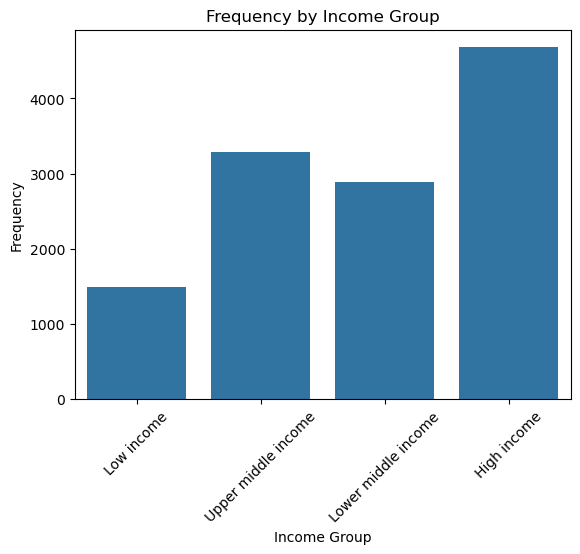

In [26]:
# Counts of income groups
sns.countplot(data=df_wbdi, x='Income group')
plt.title('Frequency by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

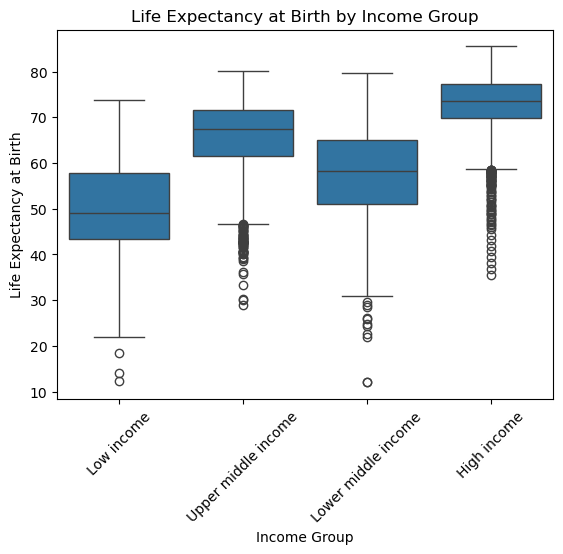

In [ ]:
# Anova test to see if there are significant differences in life expectancy across different income groups
# Plot data with box plot
# Null hypothesis H0: the means of life expectancy at birth are not significantly different between income groups
# and differences could be just by chance
# Alternative hypothesis H1: At least one mean of life expectancy of the different income groups is significantly different from the others 

sns.boxplot(data=df_wbdi, x='Income group', y='life_expectancy_at_birth')
plt.title('Life Expectancy at Birth by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Life Expectancy at Birth')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Check assumptions for ANOVA
# 1. Independent samples
# cannot be tested with the data, but we assume it is met based on study design

# Equal sample sizes of groups
group_sizes = df_wbdi['Income group'].value_counts()
print("Group sizes:\n", group_sizes)

# not equal, but we will proceed with ANOVA as it is robust to some inequality in group sizes

Group sizes:
 Income group
High income            4679
Upper middle income    3286
Lower middle income    2884
Low income             1488
Name: count, dtype: int64


In [ ]:
# Equal variances of groups
# we can look at the boxplots above
# The length of the boxplots, and therefore the variances, differ
# but one can argue that they are still similar enough to meet the assumption

In [ ]:
# Normal distribution of the dependent variable
# see histogram above
# it is not perfectly normal, but at least approximately
# with larger sample sizes ANOVA is robust to moderate deviations from normality

In [ ]:
# Rename income group to Income_group for easier access in formula
df_wbdi = df_wbdi.rename(columns={'Income group': 'Income_group'})

In [ ]:
# Run an ANOVA
formula = 'life_expectancy_at_birth ~ C(Income_group)'
model = ols(formula, data=df_wbdi).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

# we reject the null hypothesis as the p-value is less than 0.05
# There are significant differences in life expectancy at birth between different income groups.

                                 sum_sq       df                     F  PR(>F)
C(Income_group)  790690.028042559162714      3.0  4196.991473280319951     0.0
Residual         774489.709111175965518  12333.0                   NaN     NaN


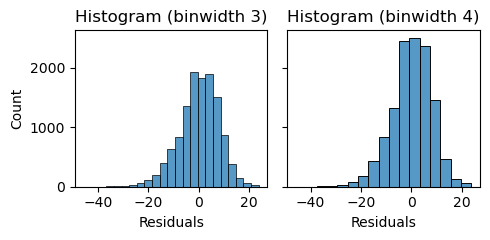

In [ ]:
# Inspect the residuals
# Extract the residuals from the model
res = model.resid

# Set up 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharey=True)

# Plot the residuals with bin width of 3
sns.histplot(res, binwidth=3, ax=axes[0])
axes[0].set_title('Histogram (binwidth 3)')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Count')

# Plot the residuals with bin width of 4
sns.histplot(res, binwidth=4, ax=axes[1])
axes[1].set_title('Histogram (binwidth 4)')
axes[1].set_xlabel('Residuals')

# Adjust layout
plt.tight_layout()
plt.show()

# The residuals appear to be approximately normally distributed, 
# which supports the validity of the ANOVA results.

In [ ]:
# Interpretation of results
# Extract the sum of squares values for the model and residuals
SS_model = anova_table['sum_sq'].iloc[:-1].sum()  
SS_residual = anova_table['sum_sq'].iloc[-1]  

# Total sum of squares
SS_total = SS_model + SS_residual

# Explained variance
explained_variance = SS_model / SS_total
print(f'Explained Variance: {explained_variance:.3f}')

# The sum of squares shows us how much variation is explained by the income group factor.
# It shows that approximately 50,5% of the variance in life expectancy at birth c
# an be explained by differences in income groups.

Explained Variance: 0.505


In [ ]:
# Run a post-hoc test (Tukey's HSD) to determine which specific groups differ
# Run Tukey HSD test
tukey = pairwise_tukeyhsd(endog=df_wbdi['life_expectancy_at_birth'], groups=df_wbdi['Income_group'], alpha=0.05)
print(tukey)

# From the results, we can see which specific income groups have significantly different life expectancies at birth.
# The results indicate that all income groups differ significantly from each other 
# in terms of life expectancy at birth.

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------------
        High income          Low income   -22.96   0.0  -23.566  -22.354   True
        High income Lower middle income -15.3906   0.0 -15.8726 -14.9086   True
        High income Upper middle income   -7.259   0.0  -7.7225  -6.7956   True
         Low income Lower middle income   7.5694   0.0   6.9195   8.2193   True
         Low income Upper middle income   15.701   0.0  15.0648  16.3372   True
Lower middle income Upper middle income   8.1316   0.0    7.612   8.6511   True
-------------------------------------------------------------------------------
